In [1]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [ ]:
# при пакетном питоне нужно такое заклинание
# conda install python-graphviz

In [22]:
from IPython.display import HTML
style = "<style>svg{width:80% !important;height:80% !important;}</style>"
HTML(style)

In [9]:
titanic_data = pd.read_csv(r"C:\Users\DEMO\Downloads\titanic\train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Предобработка данных 

In [10]:
# проверяем по каким данным нет значений (NaN) - с такими значениями классификатор не работает и они не информативны
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [115]:
# выкидываем ненужные данные (по столбцам)
X = titanic_data.drop(['PassengerId','Survived','Name', 'Ticket', 'Cabin'], axis=1)

# переменная, которую будем предсказывать
y = titanic_data.Survived

In [116]:
# для обучения классификатора необходимо все переменные привести к количественному виду 
# Label Encoding - из номинативных в количественные (https://habr.com/ru/company/ods/blog/326418/)
# разобьем некоторые колонки на несколько и сделаем их бинарными (например, мужской и женский пол)
X = pd.get_dummies(X)

In [117]:
# заполнить NaN значения средним возрастом (медиана) 
X = X.fillna({'Age': X.Age.median()})

In [118]:
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [119]:
#дерево решений
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [120]:
# обучаем классификатор
clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

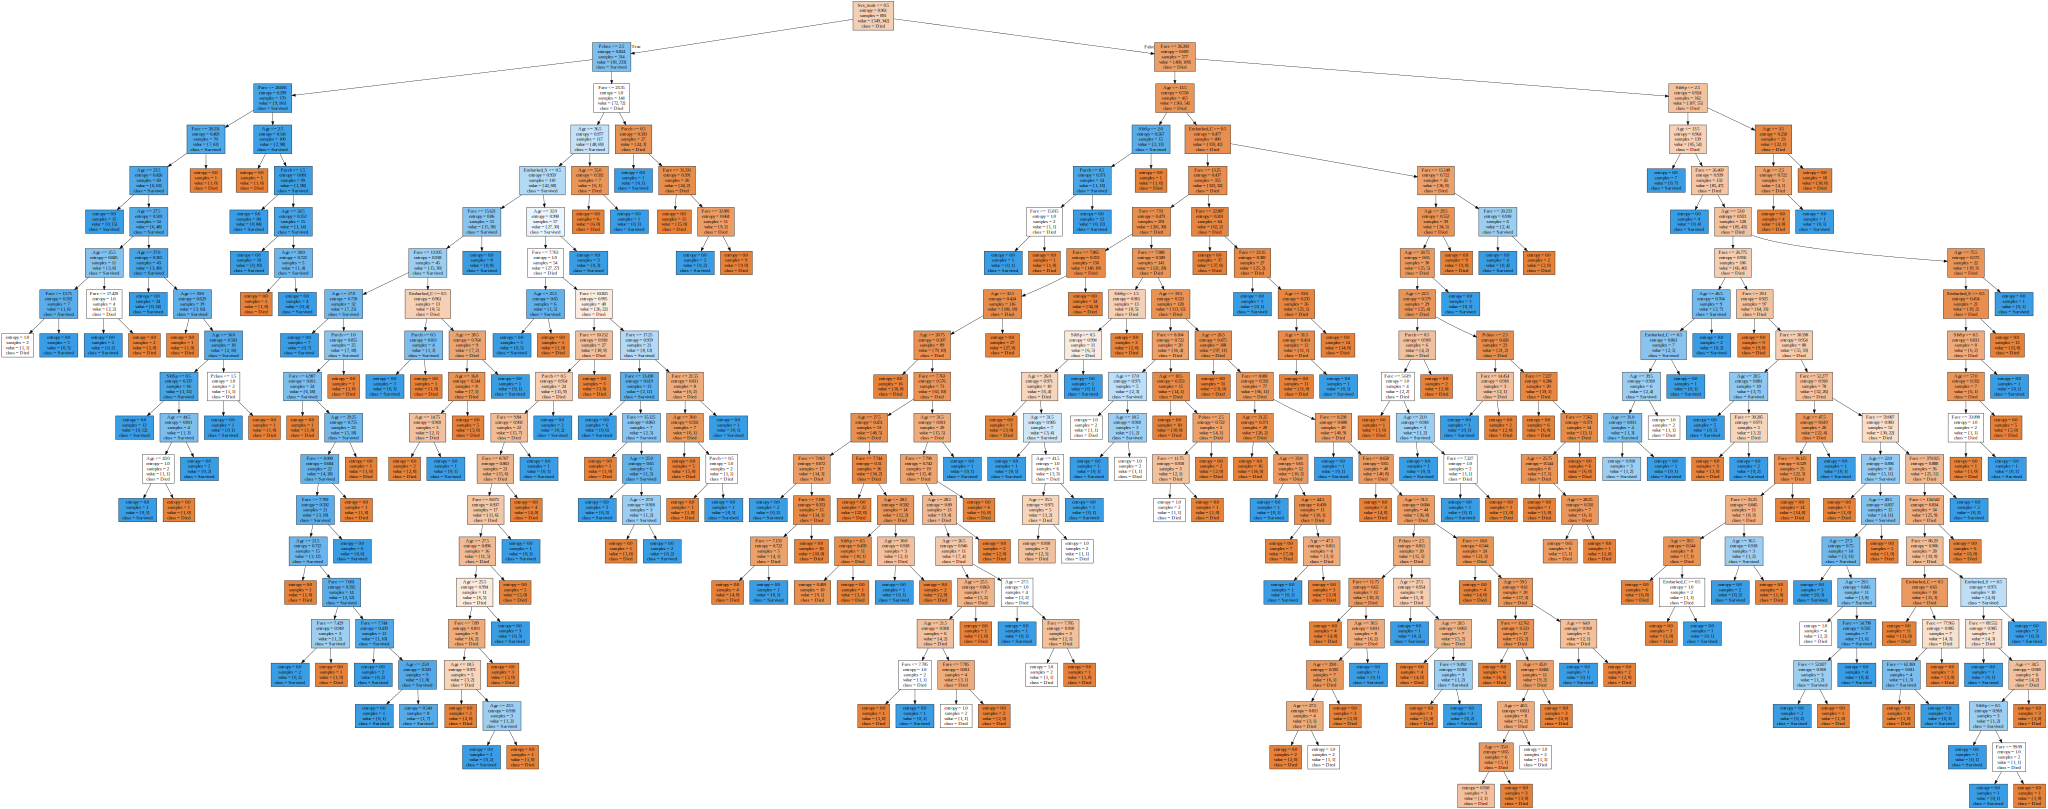

In [121]:
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X)
                                    , class_names=['Died', 'Survived']
                                    , filled=True))
display(SVG(graph.pipe(format='svg')))

#### решение проблемы переобучения - ограничение глубины дерева или использование двух выборок

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
# поделили трейн выборку на трейн и тест
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.33, random_state=42)

In [110]:
X_train.shape

(596, 10)

In [111]:
X_test.shape

(295, 10)

In [112]:
# проряем работу классификатора (процент правильных предсказываний)
clf.score(X, y)

0.7867564534231201

In [113]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [128]:
clf.score(X_train, y_train)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [127]:
# низкое качество на тестовой выборке
clf.score(X_test, y_test)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

большая разница в значениях говорит об overfitting

**ограничим глубину дерева**:

In [132]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [133]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [134]:
clf.score(X_train, y_train)

0.8406040268456376

In [135]:
clf.score(X_test, y_test)

0.8101694915254237

### эффективный подбор параметров
хотим понять, какой параметр показал себя наиболее хорошо (при какой глубине дерева лучшие результаты)

In [74]:
max_depth_values = range(1, 100)

In [73]:
scores_data = pd.DataFrame()

In [75]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [76]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.810169


https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.melt.html

In [43]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score')

In [65]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


https://stackoverflow.com/questions/51422146/install-the-latest-version-of-seaborn-0-9-0-through-pip

 pip3 install seaborn==0.9.0

In [45]:
import seaborn

In [46]:
seaborn.__version__

'0.10.0'

https://seaborn.pydata.org/generated/seaborn.lineplot.html

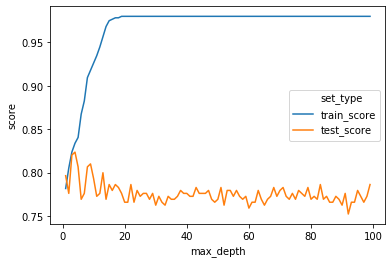

In [47]:
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long)

#### анализ графика:
- с увеличеним глубины дерева растет точность классификации на тренировочной выборке
- но это не всегда ведет к нахождению общих закономерностей исследуемых данных
- test score изначально невелик(модель ещ ене доучилась), на промежутке 3-5 score максимален(оптимальное состояние: закономерность с изученных данных переносится на новые), но в дальнейшем с увеличеним train score начинает падать test score(переход от недообученности к переобученности)

https://scikit-learn.org/stable/modules/cross_validation.html

Так выглядит возможный пример дерева с параметром максимальной глубины равным 3. Легко можно заметить, что особенно важными переменными для анализа является пол и возраст. Кстати, про то, как при помощи дерева решений вычленить фичи, максимально важные для решения конкретной задачи классификации, мы подробнее поговорим в 3 модуле курса.

Тут же обратите внимание на еще один важный момент, если бы к нам поступил новый пассажир, и мы бы захотели, предсказать для него не только значение класса но и вероятность, того что он выживет на Титанике, это было бы несложно сделать при помощи нашего дерева. Обратите внимание, цвет финальных прямоугольничков различается, соотношение выживших/погибших пассажиров различается в финальных исходах - прямоугольничках. 

Например, если бы к нам пришло новое наблюдение Sex_male <=0.05, Pclass <= 2.5, Age > 2.5,  то предсказанная вероятность выжить была бы равна 102 / (102 + 3), то есть 97%. 

Но давайте сразу поймем, что с нашим деревом не так? Обратите внимание, что данное дерево все равно выглядит переобученным, например, есть разделение, которое приводит к тому, что под условие Age <= 2.5 проходит всего два наблюдения с разными классами, запомним эту проблему деревьев и вернемся к ней позже.



обучение на нескольких подвыборках выборках:

In [50]:
# подключаем модуль для кросс-валидации
from sklearn.model_selection import cross_val_score

In [49]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [51]:
cross_val_score(clf, X_train, y_train , cv=5)

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [52]:
cross_val_score(clf, X_train, y_train , cv=5).mean()

0.7886274509803922

In [53]:
scores_data = pd.DataFrame()

In [107]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train , cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 9 

In [64]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.810169,0.800392


In [56]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score')

In [58]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


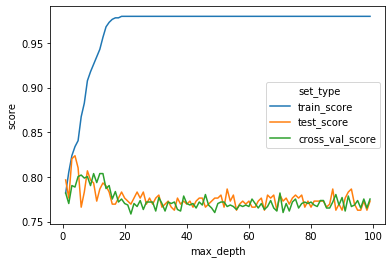

In [59]:
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long)

максимальная точность достигается при большей глубине дерева, чем 3-5

cross_val_score более устойчив к переобучению

найдем дерево с максимальным значением cross_val_score

In [60]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.800392
203,6,cross_val_score,0.802073
204,7,cross_val_score,0.798697
205,8,cross_val_score,0.800364
206,9,cross_val_score,0.790266
207,10,cross_val_score,0.803711


5	cross_val_score	0.800303

In [61]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [62]:
cross_val_score(best_clf, X_test, y_test , cv=5).mean()

0.7864406779661017

In [78]:
test_data = pd.read_csv(r"C:\Users\DEMO\Downloads\titanic\test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
